In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import utils_farouk as utils
plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [18]:
# ! ls ../eos/Apr12_presel_2017
! ls ../eos/dr_big_2017

DYJetsToLL_Pt-100To250                  SingleElectron_Run2017F
DYJetsToLL_Pt-250To400                  SingleMuon_Run2017B
DYJetsToLL_Pt-400To650                  SingleMuon_Run2017C
DYJetsToLL_Pt-50To100                   SingleMuon_Run2017D
DYJetsToLL_Pt-650ToInf                  SingleMuon_Run2017E
GluGluHToTauTau                         SingleMuon_Run2017F
GluGluHToWW_Pt-200ToInf_M-125           TTTo2L2Nu
GluGluZH_HToWW_ZTo2L_M-125              TTToHadronic
HWminusJ_HToWW_M-125                    TTToSemiLeptonic
HWplusJ_HToWW_M-125                     VBFHToWWToLNuQQ_M-125_withDipoleRecoil
HZJ_HToWW_M-125                         WJetsToLNu_HT-100To200
QCD_Pt_1000to1400                       WJetsToLNu_HT-1200To2500
QCD_Pt_1400to1800                       WJetsToLNu_HT-200To400
QCD_Pt_170to300                         WJetsToLNu_HT-2500ToInf
QCD_Pt_1800to2400                       WJetsToLNu_HT-400To600
QCD_Pt_2400to3200                       WJetsToLNu_HT-600To800
QCD_Pt_300to470 

In [4]:
# # counts number of events for a given sample after skimming
# samples_dir = "../Mar23_2017/"
# for sample in os.listdir(samples_dir):
# #     if sample != "SingleMuon_Run2017E":
# #         continue
#     out_files = f"{samples_dir}/{sample}/outfiles/"
#     parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
    
#     if not parquet_files:
#         print(f"No parquet file for {sample}")
#         continue                

#     data = pd.read_parquet(parquet_files)
#     not_empty = len(data) > 0

#     print(f"Finding {len(data)} events for {sample}")

# Read parquets
- loads parquet dataframes and combine different pT-bins per sample
- applies the preselection specefied in the next cell
- saves the combined dataframe under `events[ch][sample]`

In [5]:
presel = {
    "mu": {
#         ### already applied in processor
#         "isolation": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
#         "invert isolation": "( ( (lep_pt < 55) & (lep_isolation>0.15)) |  (lep_pt >= 55) )",

#         "mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation < 0.2) & (lep_pt >= 55) ) )",
#         "invert mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation > 0.2) & (lep_pt >= 55) ) )",

        ### preselection
#         "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
        
        ### top region
#         "nbjets": "( (n_bjets_M >= 2) )",
        
        ### wjets control region        
#         "nbjets": "( (n_bjets_M < 1) )",         
    },
    "ele": {
#         ### already applied in processor
#         "isolation": "( ( (lep_pt < 120) & (lep_isolation<0.15)) |  (lep_pt >= 120) )",    
#         "invert isolation": "( ( (lep_pt < 120) & (lep_isolation>0.15)) |  (lep_pt >= 120) )",

        ### preselection
#         "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
        
        ### top control region
#         "nbjets": "( (n_bjets_M >= 2) )",
        
        ### wjets control region        
#         "nbjets": "( (n_bjets_M < 1) )",        
    }    
}

In [24]:
year = "2017"
channels = ["mu", "ele"]

# samples_dir = f"../eos/Apr12_presel_{year}"
samples_dir = f"../eos/dr_big_{year}"

samples = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

In [25]:
events_dict = utils.event_skimmer(year, channels, samples_dir, samples, presel, "all", 
                                  add_qcd_score=True, add_top_score=True, add_inclusive_score=True,
#                                   apply_tagger=0.99,
#                                   apply_inverse_tagger=0.99,
                                 )

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 44152 events
tot event weight 70354.45920064123 

Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight

Finding ZJetsToQQ_HT-200to400 samples and should combine them under WZQQ
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WZQQ dataframe with the remaining 16 events
tot event weight 68.54992714228483 

Finding SingleElectron_Run2017E samples and should combine them under Data
Finding SingleElectron_Run2017B samples and should combine them under Data
Finding QCD_Pt_3200toInf samples and should combine them under QCD
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applyin

---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the TTbar dataframe with the remaining 3403 events
tot event weight 397.4585704585445 

Finding GluGluZH_HToWW_ZTo2L_M-125 samples and should combine them under Diboson
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
weight_vjets_nominal weight is not stored in 

---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WZQQ dataframe with the remaining 165 events
tot event weight 401.76980817745147 

Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating 

Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the SingleTop dataframe with the remaining 201066 events
tot event weight 5510.5879741831495 

Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying wei

Will fill the DYJets dataframe with the remaining 121346 events
tot event weight 18531.02153522144 

Finding QCD_Pt_1800to2400 samples and should combine them under QCD
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 838 events
tot event weight 0.4940458871352711 

Finding SingleMuon_Run2017E samples and should combine them under Data
Finding SingleMuon_Run2017B samples and should combine them under Data
Finding WW samples and should combine them under Diboson
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L

---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 465832 events
tot event weight 47696.13768724856 

Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WZQQ dataframe with the remaining 985 events
tot e

In [28]:
events_dict["mu"].keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Data', 'Diboson', 'ttH'])

In [27]:
np.isnan(data["fj_ParT_probHbb"]).sum()

0

# Plot histograms

## 1d-hists

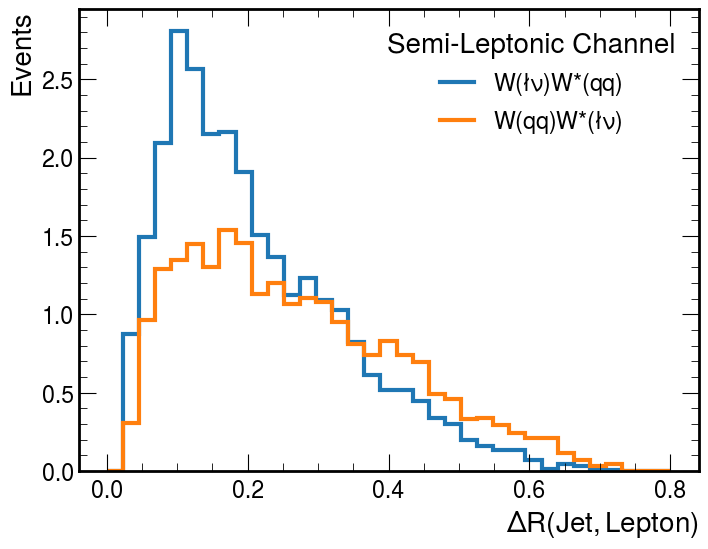

In [37]:
### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

h = hist2.Hist(
    hist2.axis.Regular(35, 0.0, 0.8, name="var", label=r"$\Delta R(Jet, Lepton)$", overflow=True),
    hist2.axis.Boolean(name="from_W")        
)

for ch in ["mu", "ele"]:
    
    h.fill(
        var=events_dict[ch]["HWW"]["lep_fj_dr"],
        from_W=events_dict[ch]["HWW"]["fj_H_VV_isVlepton"]==True,
        weight=events_dict[ch]["HWW"]["event_weight"]
    )

fig, ax = plt.subplots(figsize=(8, 6))

hep.histplot(
    h[{"from_W": 1}],
    ax=ax,
    label=r"W($\l\nu$)W*(qq)",
    linewidth=3,
#     density=True
)
hep.histplot(
    h[{"from_W": 0}],
    ax=ax,
    label=r"W(qq)W*($\l\nu$)",
    linewidth=3,
#     density=True    
)
     
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");

[autoreload of utils_farouk failed: Traceback (most recent call last):
  File "/Users/fmokhtar/miniforge3/envs/coffea-env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/fmokhtar/miniforge3/envs/coffea-env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Users/fmokhtar/miniforge3/envs/coffea-env/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/fmokhtar/projects/boostedhiggs/python/utils_farouk.py", line 189, in <module>
    score = disc_score(data, new_sig, inclusive_bkg)
NameError: name 'data' is not defined
]


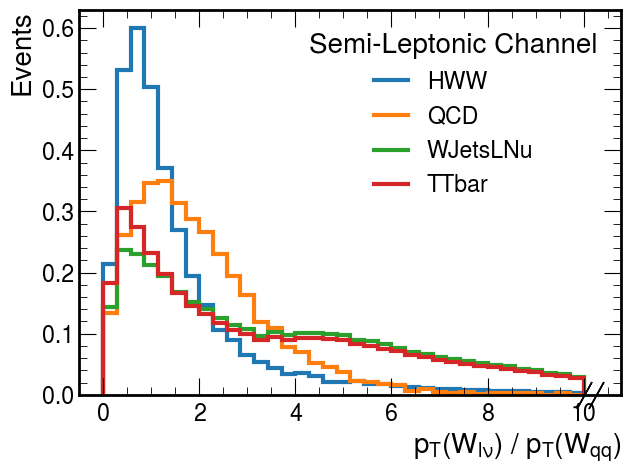

In [42]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
    "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

var = "golden_var"

h = hist2.Hist(
    utils.axis_dict[var],
)

fig, ax = plt.subplots(figsize=(7, 5))

for sample in samples_to_plot:
    for ch in channels:

        df = events_dict[ch][sample]
        
        # tagger cut
#         df = df[df["inclusive_score"]>0.9]
#         df = df[df["fj_bjets"]<0.3]
#         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]
        if var=="golden_var":
            h.fill(
                var=df["rec_W_lnu_pt"]/df["rec_W_qq_pt"],
                weight=df["event_weight"]
            ) 
        else:
            h.fill(
                var=df[var],
                weight=df["event_weight"]
            )

    hep.histplot(
        h,
        ax=ax,
        label=sample,
        linewidth=3,
        density=True
    )

ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

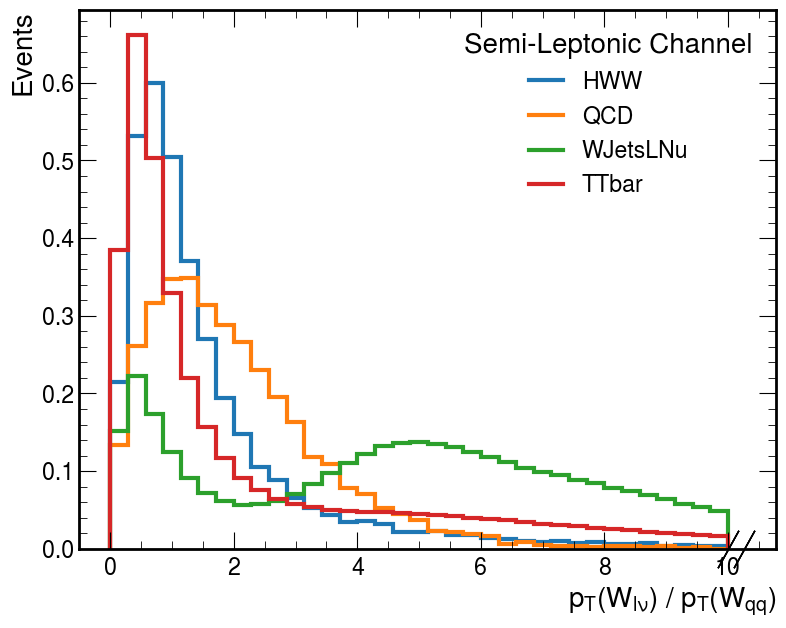

In [56]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
    "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

var = "golden_var"



fig, ax = plt.subplots(figsize=(9, 7))

for sample in samples_to_plot:
    h = hist2.Hist(
        utils.axis_dict[var],
    )    
    for ch in channels:

        df = events_dict[ch][sample]
        
        # tagger cut
#         df = df[df["inclusive_score"]>0.9]
#         df = df[df["fj_bjets"]<0.3]
#         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]
        if var=="golden_var":
            h.fill(
                var=df["rec_W_lnu_pt"]/df["rec_W_qq_pt"],
                weight=df["event_weight"]
            ) 
        else:
            h.fill(
                var=df[var],
#                 weight=df["event_weight"]
            )

    hep.histplot(
        h,
        ax=ax,
        label=sample,
        linewidth=3,
        density=True
    )

ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

In [60]:
events_dict[ch]["HWW"]

,fj_pt,fj_msoftdrop,fj_msoftdrop_nocorr,fj_mass,fj_lsf3,fj_sj1_pt,fj_sj2_pt,fj_tau3,fj_tau2,fj_bjets_ophem,...,fj_ParT_probTopbWqq0c,fj_ParT_probTopbWqq1c,fj_ParT_probTopbWq0c,fj_ParT_probTopbWq1c,fj_ParT_probTopbWev,fj_ParT_probTopbWmv,fj_ParT_probTopbWtauhv,fj_ParT_probTopbWtauev,fj_ParT_probTopbWtaumv,event_weight
0,249.250,76.513114,79.750000,79.500000,0.965332,195.8750,51.0000,0.047913,0.156860,0.009972,...,1.152786e-06,1.560133e-06,2.630430e-07,3.804964e-08,1.813849e-07,0.006639,7.393627e-07,4.400185e-08,0.000199,0.008230
1,267.000,88.254057,90.062500,90.625000,0.810059,183.8750,79.5625,0.070374,0.121582,0.012047,...,5.544140e-02,6.678279e-02,1.156003e-02,8.712733e-04,9.410286e-05,0.012678,1.938242e-03,5.691348e-05,0.001721,0.008744
2,210.375,55.767155,59.656250,60.843750,0.884766,144.0000,66.9375,0.040741,0.054626,0.007587,...,8.106355e-05,1.581909e-05,1.417136e-04,4.380445e-06,6.488000e-06,0.026838,1.528969e-05,1.257156e-06,0.000875,0.009157
3,214.625,49.734290,54.312500,55.187500,0.929199,165.1250,49.6875,0.044189,0.056152,0.196899,...,3.625584e-06,2.509597e-06,7.100236e-06,8.902909e-07,6.022232e-06,0.456090,2.026283e-05,1.419166e-06,0.016213,0.007876
4,243.000,13.886867,12.867188,26.015625,0.427246,117.4375,113.7500,0.014580,0.019089,0.005749,...,8.526646e-07,3.565411e-07,8.299072e-08,1.362080e-08,8.662099e-08,0.000365,6.359829e-07,7.950824e-09,0.000008,0.007942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19289,212.875,45.605441,50.718750,51.875000,0.653320,167.5000,45.9375,0.056580,0.089478,0.306641,...,3.433831e-05,2.092180e-05,1.010564e-06,1.471625e-07,2.346235e-06,0.001959,4.641056e-06,7.027304e-07,0.000148,0.008134
19290,290.500,55.366671,59.000000,72.437500,0.933594,151.1250,124.3125,0.063965,0.104675,0.055389,...,7.229682e-06,1.809509e-06,4.607914e-07,5.010525e-08,1.021716e-07,0.001796,8.965002e-07,3.051607e-08,0.000114,0.008428
19291,266.500,36.745674,37.093750,51.750000,0.920898,156.5000,86.5000,0.053955,0.073425,0.131470,...,3.027719e-05,2.416149e-05,2.768018e-05,2.606053e-06,1.046045e-05,0.180274,4.731803e-05,2.479765e-06,0.007825,0.008968
19292,221.375,43.091953,45.312500,47.531250,0.986328,143.8750,71.0625,0.038086,0.056366,0.008125,...,6.289637e-06,4.104209e-06,3.920916e-06,7.816878e-07,7.085765e-06,0.698410,1.706222e-05,1.402862e-06,0.027909,0.008250


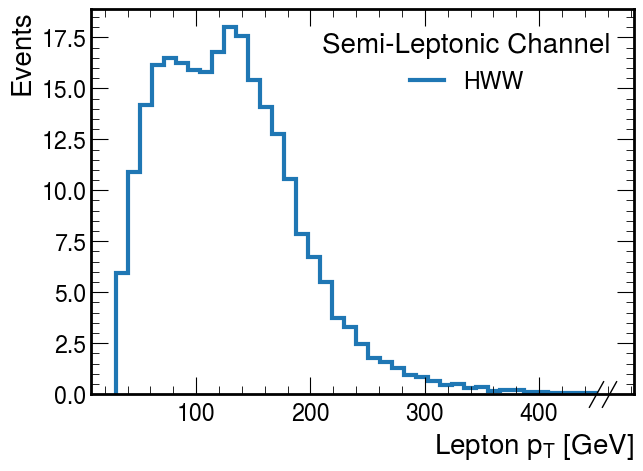

In [67]:
fig, ax = plt.subplots(figsize=(7, 5))

h = hist2.Hist(
    hist2.axis.Regular(40, 30, 450, name="var", label=r"Lepton $p_T$ [GeV]", overflow=True),
)    
for ch in channels:

    df = events_dict[ch]["HWW"]

    h.fill(
        var=df["lep_pt"],
        weight=df["event_weight"]
    )

hep.histplot(
    h,
    ax=ax,
    label="HWW",
    linewidth=3,
#     density=True
)

ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

In [68]:
h.sum()

255.86600130141332

## Stacked hists

In [29]:
# plot histograms
color_by_sample = {
    "HWW": "pink",
    "VH": "tab:brown",
    "VBF": "tab:gray",
    "ttH": "tab:olive",
    
    "DYJets": "tab:purple",
    "QCD": "tab:orange",
    "Diboson": "orchid",    
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "WZQQ": "salmon",
    "SingleTop": "tab:cyan",
    
#     "WplusHToTauTau": "tab:cyan",
#     "WminusHToTauTau": "tab:cyan",
#     "ttHToTauTau": "tab:cyan",
#     "GluGluHToTauTau": "tab:cyan",
#     "ZHToTauTau": "tab:cyan",
#     "VBFHToTauTau": "tab:cyan",
}

plot_labels = {
    "HWW": "ggH(WW)-Pt200",    
    "VH": "VH(WW)",
    "VBF": r"VBFH(WW) $(qq\ell\nu)$",
    "ttH": "ttH(WW)",
    
    "DYJets": r"Z$(\ell\ell)$+jets",    
    "QCD": "Multijet",
    "Diboson": "VV",
    "WJetsLNu": r"W$(\ell\nu)$+jets",
    "TTbar": r"$t\bar{t}$+jets",
    "WZQQ": r"W/Z$(qq)$",
    "SingleTop": r"Single Top",
    
#     "WplusHToTauTau": "WplusHToTauTau",
#     "WminusHToTauTau": "WminusHToTauTau",
#     "ttHToTauTau": "ttHToTauTau",
#     "GluGluHToTauTau": "GluGluHToTauTau",
#     "ZHToTauTau": "ZHToTauTau",
#     "VBFHToTauTau": "VBFHToTauTau"
}

sig_labels = {
    "HWW": "ggF",
    "VBF": "VBF",
    "VH": "VH",
    "ttH": "ttH",
}

label_by_ch = {
    "mu": "Muon",
    "ele": "Electron"
}

def plot_hists(year, channels, hists, vars_to_plot, add_data = True, logy = True, add_soverb = True, only_sig = False, mult=100, tag=""):

    # luminosity
    luminosity = 0
    for ch in channels:
        
#         for yr in ["2017", "2016", "2018", "2016APV"]:
        with open("../fileset/luminosity.json") as f:
            lum = json.load(f)[ch][year]
            luminosity += lum / 1000.0

    luminosity = luminosity/len(channels)
        
    for var in vars_to_plot:
        if var not in hists.keys():
            print(f"{var} not stored in hists")
            continue

        print(f"Will plot {var} histogram")

        # get histograms
        h = hists[var]

        if (h.shape[0] == 0):  # skip empty histograms (such as lepton_pt for hadronic channel)
            print("Empty histogram ", var)
            continue

        # get samples existing in histogram
        samples = [h.axes[0].value(i) for i in range(len(h.axes[0].edges))]
        signal_labels = [label for label in samples if label in utils.signals]
        bkg_labels = [
            label
            for label in samples
            if (label and label not in signal_labels and (label not in ["Data"]))
        ]

        # get total yield of backgrounds per label
        # (sort by yield in fixed fj_pt histogram after pre-sel)        
        order_dic = {}
        for bkg_label in bkg_labels:
            if "fj_pt" in hists.keys():
                order_dic[plot_labels[bkg_label]] = hists["fj_pt"][{"samples": bkg_label}].sum()
            else:
                order_dic[plot_labels[bkg_label]] = hists[var][{"samples": bkg_label}].sum()
            
        # data
        if add_data:
            data = h[{"samples": "Data"}]

        # signal
        signal = [h[{"samples": label}] for label in signal_labels]
        # scale signal for non-log plots
        if logy:
            mult_factor = 1
        else:
            mult_factor = mult
        signal_mult = [s * mult_factor for s in signal]

        # background
        bkg = [h[{"samples": label}] for label in bkg_labels]

        if add_data and data and len(bkg) > 0:
            if add_soverb and len(signal) > 0:
                fig, (ax, rax, sax) = plt.subplots(
                    nrows=3,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1, 1), "hspace": 0.07},
                    sharex=True,
                )
            else:
                fig, (ax, rax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                sax = None
        else:
            if add_soverb and len(signal) > 0:
                fig, (ax, sax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                rax = None
            else:
                fig, ax = plt.subplots(figsize=(8,8))                
                rax = None
                sax = None

        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
        }

        # sum all of the background
        if len(bkg) > 0:
            tot = bkg[0].copy()
            for i, b in enumerate(bkg):
                if i > 0:
                    tot = tot + b

            tot_val = tot.values()
            tot_val_zero_mask = tot_val == 0
            tot_val[tot_val_zero_mask] = 1

            tot_err = np.sqrt(tot_val)
            tot_err[tot_val_zero_mask] = 0

        if add_data and data:
            data_err_opts = {
                "linestyle": "none",
                "marker": ".",
                "markersize": 10.0,
                "elinewidth": 1,
            }
            hep.histplot(
                data,
                ax=ax,
                histtype="errorbar",
                color="k",
                capsize=4,
                yerr=True,
                label="Data",
                **data_err_opts,
            )

            if len(bkg) > 0:
                from hist.intervals import ratio_uncertainty

                data_val = data.values()
                data_val[tot_val_zero_mask] = 1

                yerr = ratio_uncertainty(data_val, tot_val, "poisson")

                hep.histplot(
                    data_val / tot_val,
                    tot.axes[0].edges,
                    yerr=yerr,
                    ax=rax,
                    histtype="errorbar",
                    color="k",
                    capsize=4,
                )

                rax.axhline(1, ls="--", color="k")
                rax.set_ylim(0.2, 1.8)

        # plot the background
        if len(bkg) > 0 and not only_sig:
            hep.histplot(
                bkg,
                ax=ax,
                stack=True,
                sort="yield",
                edgecolor="black",
                linewidth=1,
                histtype="fill",
                label=[plot_labels[bkg_label] for bkg_label in bkg_labels],
                color=[color_by_sample[bkg_label] for bkg_label in bkg_labels],
            )
            ax.stairs(
                values=tot.values() + tot_err,
                baseline=tot.values() - tot_err,
                edges=tot.axes[0].edges,
                **errps,
                label="Stat. unc.",
            )

        # plot the signal (times 10)
        if len(signal) > 0:
            tot_signal = None
            for i, sig in enumerate(signal_mult):
                lab_sig_mult = f"{mult_factor} * {plot_labels[signal_labels[i]]}"
                if mult_factor == 1:
                    lab_sig_mult = f"{plot_labels[signal_labels[i]]}"
                hep.histplot(
                    sig,
                    ax=ax,
                    label=lab_sig_mult,
                    linewidth=3,
                    color=color_by_sample[signal_labels[i]],
                )

                if tot_signal == None:
                    tot_signal = signal[i].copy()
                else:
                    tot_signal = tot_signal + signal[i]

            # plot the total signal (w/o scaling)
            hep.histplot(
                tot_signal, ax=ax, label=f"ggF+VBF+VH+ttH", linewidth=3, color="tab:red"
            )
            # add MC stat errors
            ax.stairs(
                values=tot_signal.values() + np.sqrt(tot_signal.values()),
                baseline=tot_signal.values() - np.sqrt(tot_signal.values()),
                edges=sig.axes[0].edges,
                **errps,
            )

            if sax is not None:
                totsignal_val = tot_signal.values()
                # replace values where bkg is 0
                totsignal_val[tot_val == 0] = 0
                soverb_val = totsignal_val / np.sqrt(tot_val)
                hep.histplot(
                    soverb_val,
                    tot_signal.axes[0].edges,
                    label="Total Signal",
                    ax=sax,
                    linewidth=3,
                    color="tab:red",
                )

                # integrate soverb in a given range for fj_minus_lep_mass (which, intentionally, is the first variable we pass)
                if var == "fj_minus_lep_m":
                    bin_array = tot_signal.axes[0].edges[
                        :-1
                    ]  # remove last element since bins have one extra element
                    range_max = 150
                    range_min = 0

                    condition = (bin_array >= range_min) & (bin_array <= range_max)

                    s = totsignal_val[
                        condition
                    ].sum()  # sum/integrate signal counts in the range
                    b = np.sqrt(
                        tot_val[condition].sum()
                    )  # sum/integrate bkg counts in the range and take sqrt

                    soverb_integrated = round((s / b).item(), 2)
                    sax.legend(title=f"S/sqrt(B) (in 0-150)={soverb_integrated:.2f}")
                # integrate soverb in a given range for fj_minus_lep_mass (which, intentionally, is the first variable we pass)
                if var == "rec_higgs_m":
                    bin_array = tot_signal.axes[0].edges[
                        :-1
                    ]  # remove last element since bins have one extra element
                    range_max = 200
                    range_min = 50

                    condition = (bin_array >= range_min) & (bin_array <= range_max)

                    s = totsignal_val[
                        condition
                    ].sum()  # sum/integrate signal counts in the range
                    b = np.sqrt(
                        tot_val[condition].sum()
                    )  # sum/integrate bkg counts in the range and take sqrt

                    soverb_integrated = round((s / b).item(), 2)
                    sax.legend(title=f"S/sqrt(B) (in 50-200)={soverb_integrated:.2f}")

        ax.set_ylabel("Events")
        if sax is not None:
            ax.set_xlabel("")
            if rax is not None:
                rax.set_xlabel("")
                rax.set_ylabel("Data/MC", fontsize=20)
            sax.set_ylabel(r"S/$\sqrt{B}$", fontsize=20)
            sax.set_xlabel(f"{h.axes[-1].label}")   # assumes the variable to be plotted is at the last axis
            
        elif rax is not None:
            ax.set_xlabel("")
            rax.set_xlabel(f"{h.axes[-1].label}")    # assumes the variable to be plotted is at the last axis
            
            rax.set_ylabel("Data/MC", fontsize=20)

        # get handles and labels of legend
        handles, labels = ax.get_legend_handles_labels()

        # append legend labels in order to a list
        summ = []
        for label in labels[: len(bkg_labels)]:
            summ.append(order_dic[label])
        # get indices of labels arranged by yield
        order = []
        for i in range(len(summ)):
            order.append(np.argmax(np.array(summ)))
            summ[np.argmax(np.array(summ))] = -100

        # plot data first, then bkg, then signal
        hand = [handles[-1]] + [handles[i] for i in order] + handles[len(bkg) : -1]
        lab = [labels[-1]] + [labels[i] for i in order] + labels[len(bkg) : -1]

        if len(channels) == 2:
            ax.legend(
                [hand[idx] for idx in range(len(hand))],
                [lab[idx] for idx in range(len(lab))],
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
                title=f"Semi-Leptonic Channel",
            )        
        else:
            ax.legend(
                [hand[idx] for idx in range(len(hand))],
                [lab[idx] for idx in range(len(lab))],
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
                title=f"{label_by_ch[ch]} Channel",
            )
        
        if logy:
            ax.set_yscale("log")
            ax.set_ylim(1e-1)

        hep.cms.lumitext(
            "%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20
        )
        hep.cms.text("Work in Progress", ax=ax, fontsize=15)
        
        ### save plot
        save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
        if not os.path.exists(save_as):
            os.makedirs(save_as)
        
        save_as += tag
        if not os.path.exists(save_as):
            os.makedirs(save_as)
        
        plt.savefig(f"{save_as}/{var}.pdf", bbox_inches='tight')

In [37]:
vars_to_plot = [
#     "fj_minus_lep_m",
#     "fj_pt",
#     "lep_pt",
#     "fj_msoftdrop",
#     "fj_bjets_ophem",
#     "fj_bjets",
    "lep_fj_dr",
#     "lep_met_mt",
#     "ht",
#     "met_fj_dphi",
#     "deta",
#     "met",
#     "mjj",
#     "fj_pt_over_lep_pt",
#     "rec_higgs_m",
#     "rec_higgs_pt",
#     "rec_higgs_pt_over_lep_pt",    
#     "golden_var",
#     "rec_dphi_WW",
#     "fj_ParT_mass",
#     "fj_ParticleNet_mass"
]

samples_to_plot = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data",
]

In [40]:
channels = ["ele", "mu"]

# fill histograms
hists = {}
for var in vars_to_plot:
            
    hists[var] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
#         utils.axis_dict[var],
        hist2.axis.Regular(25, 0.0, 2.5, name="var", label=r"$\Delta R(Jet, Lepton)$", overflow=True)
    )
        
    for sample in samples_to_plot:
        for ch in channels:
            df = events_dict[ch][sample]
            
#             df = df[df["fj_pt"]>650]
#             df = df[df["fj_pt"]<650]            
            
#             # tagger cut
#             df = df[df["inclusive_score"] > 0.99]

#             df = df[df["fj_minus_lep_m"]>70]
#             df = df[df["lep_fj_dr"]>0.5]
            
            # lep and jet overlap cut
#             df = df[df["fj_pt"]/df["lep_pt"]>1.6]            
#             df = df[df["lep_fj_dr"]>0.01]
    
#             # WJetsLNu control region
#             df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<2]

#             # TTbar control region
#             df = df[df["n_bjets_M"]<2]
 
#             df = df[df["met"]<100]
            
            if var=="golden_var":
                hists[var].fill(
                    samples=sample,
                    var=df["rec_W_lnu_pt"]/df["rec_W_qq_pt"],
                    weight=df["event_weight"]
                )                 
            elif var == "fj_pt_over_lep_pt":
                hists[var].fill(
                    samples=sample,
                    var=df["fj_pt"]/df["lep_pt"],
                    weight=df["event_weight"]
                )
            elif var=="rec_higgs_pt_over_lep_pt":
                hists[var].fill(
                    samples=sample,
                    var=df["rec_higgs_pt"]/df["lep_pt"],
                    weight=df["event_weight"]
                )                
            elif var=="rec_dphi_WW":
                hists[var].fill(
                    samples=sample,
                    var=np.abs(df["rec_dphi_WW"]),
                    weight=df["event_weight"]
                )     
            elif var=="fj_msoftdrop+met":
                hists[var].fill(
                    samples=sample,
                    var=df["fj_msoftdrop"]+df["met"],
                    weight=df["event_weight"]
                )   
            elif var=="fj_ParT_mass-met":
                hists[var].fill(
                    samples=sample,
                    var=df["fj_ParT_mass"]-df["met"],
                    weight=df["event_weight"]
                )  
            elif var=="met_fj_dphi":
                hists[var].fill(
                    samples=sample,
                    var=np.abs(df["met_fj_dphi"]),
                    weight=df["event_weight"]
                )                  
            else:
                hists[var].fill(
                    samples=sample,
                    var=df[var],
                    weight=df["event_weight"]
                )

# hists["fj_pt"][{"samples": "HWW"}]        

Will plot lep_fj_dr histogram


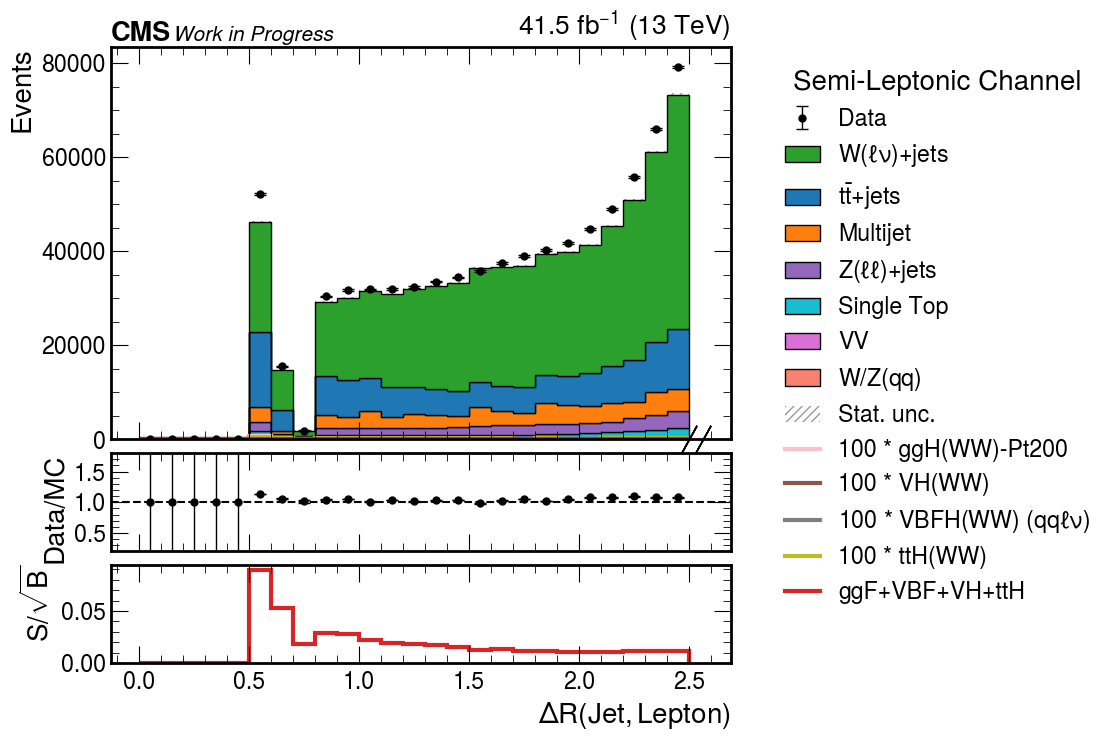

In [41]:
plt.rcParams.update({"font.size": 20})
plot_hists(year, channels, hists, vars_to_plot, logy = False, mult=100, add_data=True, tag="")

In [ ]:
samples_to_plot = [
    "HWW", 
#     "VH",
    "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

var = "rec_higgs_m"

h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    utils.axis_dict[var],
)  
    
fig, ax = plt.subplots(figsize=(9, 7))

for sample in samples_to_plot:
  
    for ch in channels:

        df = events_dict[ch][sample]
        
        # tagger cut
        df = df[df["inclusive_score"]>0.99]
        
#         df = df[df["lep_fj_dr"]>0.03]        
#         df = df[df["n_bjets_M"]<2]
#         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

        h.fill(
            samples=sample,
            var=df[var],
            weight=df["event_weight"]
        )

for sample in samples_to_plot:
    if sample in sig_labels:
        lab = sig_labels[sample]
    else:
        lab = sample
        
    hep.histplot(
        h[{"samples":sample}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

ax.legend(title=f"Tagger cut > 0.99")
ax.set_ylabel("Events");  
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

### save plot
save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
if not os.path.exists(save_as):
    os.makedirs(save_as)

# plt.savefig(f"{save_as}/1d-{var}_tagger_cut_99.pdf", bbox_inches='tight')

# 1d plots

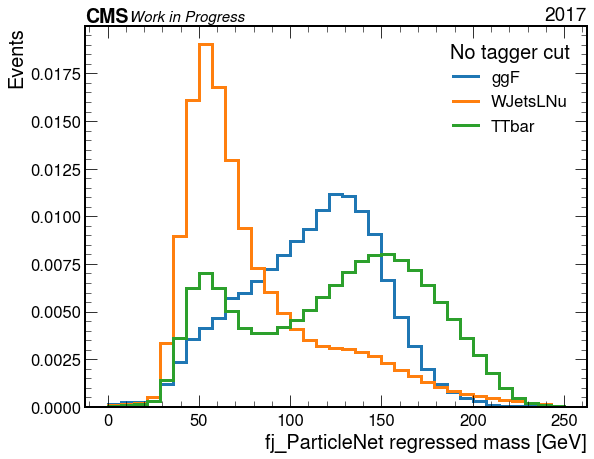

In [121]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

var = "fj_ParticleNet_mass"
# var = "met_fj_dphi"
# var = "lep_met_mt"
# var = "mjj"


h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    utils.axis_dict[var],
)  
    
fig, ax = plt.subplots(figsize=(9, 7))

for sample in samples_to_plot:
  
    for ch in channels:

        df = events_dict[ch][sample]
        
        # tagger cut
#         df = df[df["inclusive_score"]>0.9]
        
#         df = df[df["lep_fj_dr"]>0.03]        
#         df = df[df["n_bjets_M"]<2]
#         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

        h.fill(
            samples=sample,
            var=df[var],
            weight=df["event_weight"]
        )

for sample in samples_to_plot:
    if sample in sig_labels:
        lab = sig_labels[sample]
    else:
        lab = sample
        
    hep.histplot(
        h[{"samples":sample}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"No tagger cut")
ax.set_ylabel("Events");  
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

### save plot
save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
if not os.path.exists(save_as):
    os.makedirs(save_as)

plt.savefig(f"{save_as}/1d-{var}_no_tagger_cut.pdf", bbox_inches='tight')

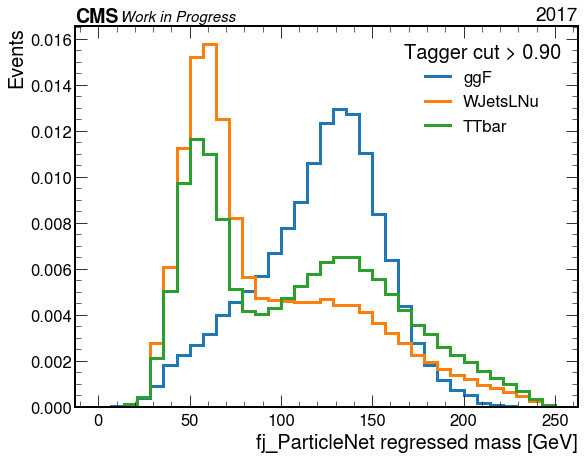

In [122]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

var = "fj_ParticleNet_mass"
# var = "met_fj_dphi"
# var = "lep_met_mt"
# var = "mjj"


h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    utils.axis_dict[var],
)  
    
fig, ax = plt.subplots(figsize=(9, 7))

for sample in samples_to_plot:
  
    for ch in channels:

        df = events_dict[ch][sample]
        
        # tagger cut
        df = df[df["inclusive_score"]>0.9]
        
#         df = df[df["lep_fj_dr"]>0.03]        
#         df = df[df["n_bjets_M"]<2]
#         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

        h.fill(
            samples=sample,
            var=df[var],
            weight=df["event_weight"]
        )

for sample in samples_to_plot:
    if sample in sig_labels:
        lab = sig_labels[sample]
    else:
        lab = sample
        
    hep.histplot(
        h[{"samples":sample}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

ax.legend(title=f"Tagger cut > 0.90")
ax.set_ylabel("Events");  
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

### save plot
save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
if not os.path.exists(save_as):
    os.makedirs(save_as)

plt.savefig(f"{save_as}/1d-{var}_tagger_cut_90.pdf", bbox_inches='tight')

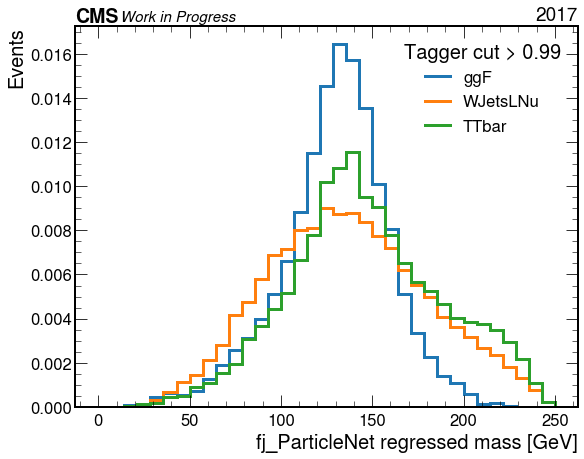

In [123]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

var = "fj_ParticleNet_mass"
# var = "met_fj_dphi"
# var = "lep_met_mt"
# var = "mjj"


h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    utils.axis_dict[var],
)  
    
fig, ax = plt.subplots(figsize=(9, 7))

for sample in samples_to_plot:
  
    for ch in channels:

        df = events_dict[ch][sample]
        
        # tagger cut
        df = df[df["inclusive_score"]>0.99]
        
#         df = df[df["lep_fj_dr"]>0.03]        
#         df = df[df["n_bjets_M"]<2]
#         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

        h.fill(
            samples=sample,
            var=df[var],
            weight=df["event_weight"]
        )

for sample in samples_to_plot:
    if sample in sig_labels:
        lab = sig_labels[sample]
    else:
        lab = sample
        
    hep.histplot(
        h[{"samples":sample}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

ax.legend(title=f"Tagger cut > 0.99")
ax.set_ylabel("Events");  
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

### save plot
save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
if not os.path.exists(save_as):
    os.makedirs(save_as)

plt.savefig(f"{save_as}/1d-{var}_tagger_cut_99.pdf", bbox_inches='tight')

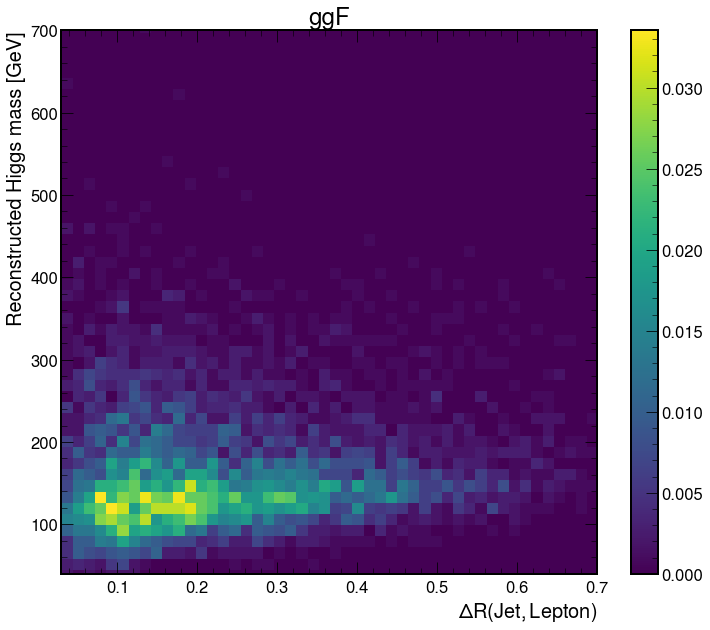

In [51]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
#     "WJetsLNu",
#     "TTbar",
]

var1 = "lep_fj_dr"
var2 = "rec_higgs_m"

from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(12, 10))

for sample in samples_to_plot:
    for i, ch in enumerate(channels):
        df = events_dict[ch][sample]
        
        df = df[df["inclusive_score"]>0.99]
        df = df[df["fj_pt"]>220]
        
        if i==0:
            dff = df
        else:
            dff = pd.concat([dff, df])
        

    x = dff[var1].dropna()
    y = dff[var2].dropna()

    plt.hist2d(
        x,
        y,
        density=True,
#         norm=LogNorm(),
        bins=[50,50]
          )

ax.set_xlim(0.03,0.7)
ax.set_ylim(40, 700)
ax.set_xlabel(r"$\Delta R(Jet,Lepton)}$");
ax.set_ylabel(r"Reconstructed Higgs mass [GeV]");
ax.set_title(sig_labels[sample])
plt.colorbar()

### save plot
save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
plt.savefig(f"{save_as}/2d-{var1}-{var2}-{sample}.pdf", bbox_inches='tight')

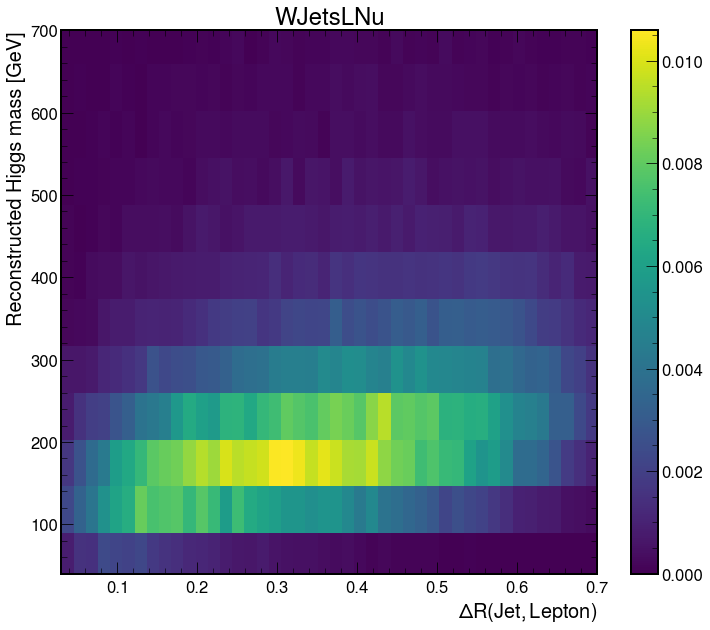

In [50]:
samples_to_plot = [
#     "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
#     "TTbar",
]

var1 = "lep_fj_dr"
var2 = "rec_higgs_m"

from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(12, 10))

for sample in samples_to_plot:
    for i, ch in enumerate(channels):
        df = events_dict[ch][sample]
        
        df = df[df["inclusive_score"]>0.99]
        df = df[df["fj_pt"]>220]
        
        if i==0:
            dff = df
        else:
            dff = pd.concat([dff, df])
        

    x = dff[var1].dropna()
    y = dff[var2].dropna()

    plt.hist2d(
        x,
        y,
        density=True,
#         norm=LogNorm(),
        bins=[50,50]
          )

ax.set_xlim(0.03,0.7)
ax.set_ylim(40, 700)
ax.set_xlabel(r"$\Delta R(Jet,Lepton)}$");
ax.set_ylabel(r"Reconstructed Higgs mass [GeV]");
ax.set_title(sample)
plt.colorbar()

### save plot
save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
plt.savefig(f"{save_as}/2d-{var1}-{var2}-{sample}.pdf", bbox_inches='tight')

# ggF and VBF

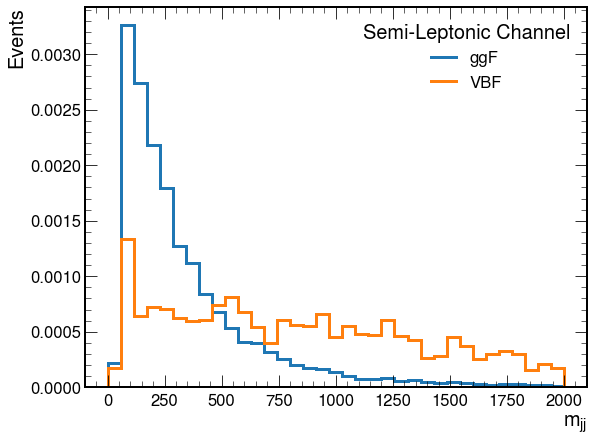

In [112]:
plt.rcParams.update({"font.size": 20})

samples_to_plot = [
    "HWW", 
    "VBF",
]

var = "mjj"

h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    utils.axis_dict[var],
)  
    
fig, ax = plt.subplots(figsize=(9, 7))

for sample in samples_to_plot:
  
    for ch in channels:

        df = events_dict[ch][sample]
        
        # tagger cut
        df = df[df["inclusive_score"]>0.9]
        
#         df = df[df["lep_fj_dr"]>0.03]        
#         df = df[df["n_bjets_M"]<2]
#         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

        h.fill(
            samples=sample,
            var=df[var],
            weight=df["event_weight"]
        )

for sample in samples_to_plot:
    if sample in sig_labels:
        lab = sig_labels[sample]
    else:
        lab = sample
        
    hep.histplot(
        h[{"samples":sample}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

### save plot
tag = "signal_region"

save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
if not os.path.exists(save_as):
    os.makedirs(save_as)

save_as += tag
if not os.path.exists(save_as):
    os.makedirs(save_as)

plt.savefig(f"{save_as}/1d-{var}.pdf", bbox_inches='tight')

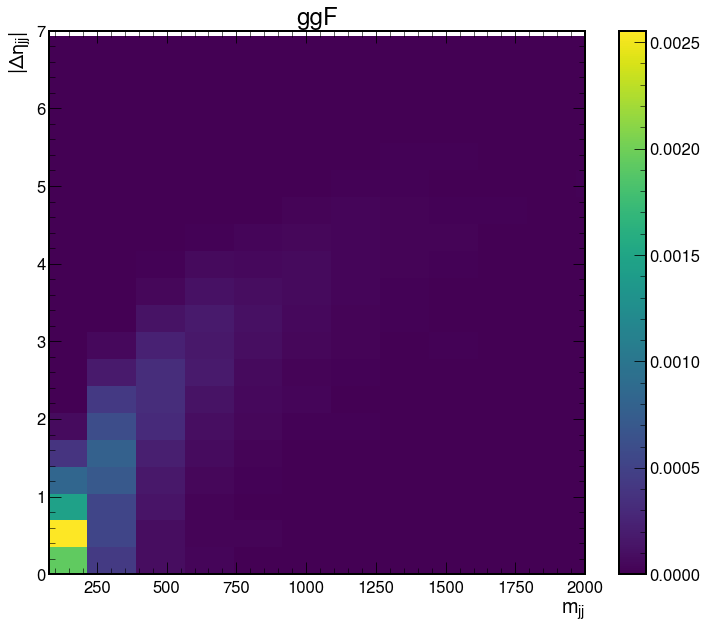

In [110]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
#     "WJetsLNu",
#     "TTbar",
]

var1 = "mjj"
var2 = "deta"

from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(12, 10))

for sample in samples_to_plot:
    for i, ch in enumerate(channels):
        df = events_dict[ch][sample]
        df = df[df["inclusive_score"]>0.9]
        
        if i==0:
            dff = df
        else:
            dff = pd.concat([dff, df])
        

    x = dff[var1].dropna()
    y = dff[var2].dropna()

    plt.hist2d(
        x,
        y,
        density=True,
#         norm=LogNorm(),
        bins=[30,20]
          )

ax.set_xlim(80,2000)
ax.set_ylim(0, 7)
ax.set_xlabel(r"$m_{jj}$");
ax.set_ylabel(r"$|\Delta \eta_{jj}|$");
ax.set_title(sig_labels[sample])
plt.colorbar()

### save plot

tag = "signal_region"

save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
if not os.path.exists(save_as):
    os.makedirs(save_as)

save_as += tag
if not os.path.exists(save_as):
    os.makedirs(save_as)

plt.savefig(f"{save_as}/2d-{var1}-{var2}-{sample}.pdf", bbox_inches='tight')

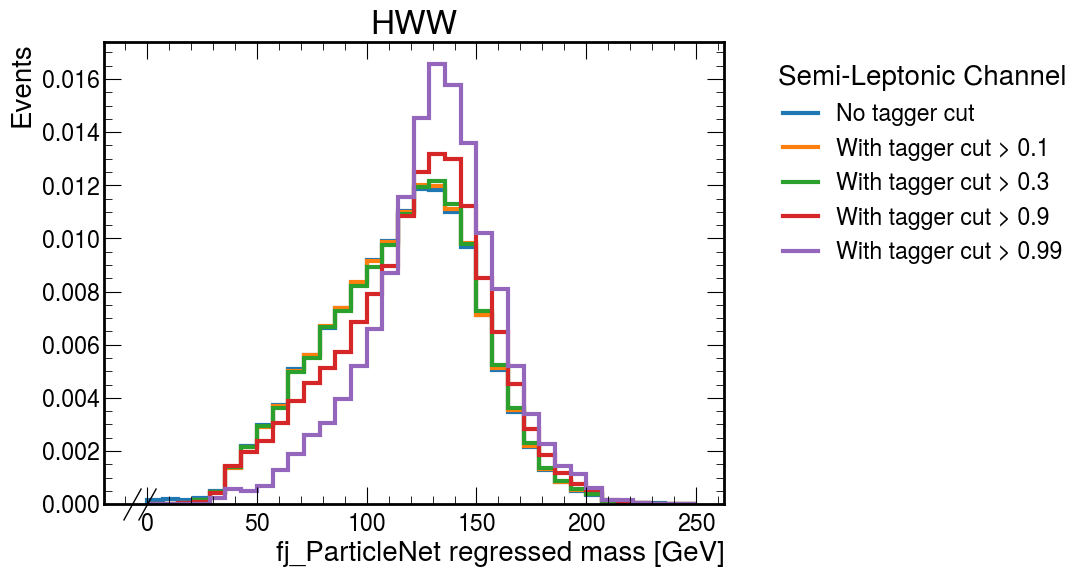

In [93]:
plt.rcParams.update({"font.size": 20})

samples_to_plot = [
#     "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#     "QCD",
#     "DYJets",
    "WJetsLNu",
#     "TTbar",
]

sample = "HWW"

var = "fj_ParticleNet_mass"

h = hist2.Hist(
    hist2.axis.StrCategory([], name="cuts", growth=True),    
    utils.axis_dict[var],
)

cuts = [0, 0.1, 0.3, 0.9, 0.99]
for cut in cuts:
    for ch in channels:

        df = events_dict[ch][sample]
        
        # tagger cut
        df = df[df["inclusive_score"]>cut]
        
        h.fill(
            cuts=str(cut),
            var=df[var],
            weight=df["event_weight"]
        )

fig, ax = plt.subplots(figsize=(8, 6))
for cut in cuts:
    if cut==0:
        lab = "No tagger cut"
    else:
        lab = f"With tagger cut > {cut}"
        
    hep.histplot(
        h[{"cuts": str(cut)}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

ax.legend(title=f"Semi-Leptonic Channel", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_title(sample)
# ax.set_yscale("log")
ax.set_ylabel("Events");  